In [12]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
import numba 

import pickle
from pcygni_5 import PcygniCalculator
import astropy.units as units
import astropy.constants as csts
from scipy.interpolate import interp1d
import lmfit
import time

#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize):
    plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    #plt.rcParams['pcolor.shading'] = 'nearest'
    
def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top   = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6 , zorder = 1, top   = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6 , zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)
        
import math
pi = np.pi; h = 6.626e-34; c = 3.0e+8; k = 1.38e-23

In [13]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)
    warnings.warn("IntegrationWarning", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    
import warnings
warnings.filterwarnings("ignore")

In [14]:
OB = 'OB2'

In [15]:
path = '../spectra_filtered' #\AT2017gfo\AT2017gfo\dereddened+deredshifted_spectra' 
files = os.listdir(path)

x = np.loadtxt(path+'/'+files[1]).T
#x= np.array([wl, flux, error,error]).T
exc_reg_2 = (~((x[:,0] > 13100) & (x[:,0] < 14400))) & (~((x[:,0] > 17550) & (x[:,0] < 19200))) & \
          (~((x[:,0] > 5330) & (x[:,0] < 5740))) & (~((x[:,0] > 9840) & (x[:,0] < 10300))) & \
          (x[:,0] > 4000) & (x[:,0] < 22500)

wl, flux, error = x[:,0][exc_reg_2], x[:,1][exc_reg_2], x[:,2][exc_reg_2]
error = error

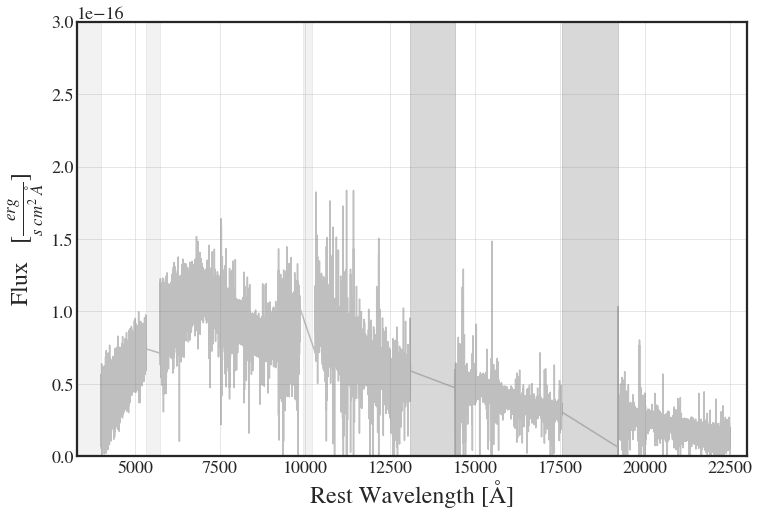

In [16]:
reset_plt(18,24)
fig,ax = plt.subplots(figsize=(12,8))
plt.plot(wl, flux, label='X-shooter spectra', color='grey', alpha=0.5)

#plt.plot(wl,flux_fit, ls='--', color='k', label='Blackbody-fit')
#plt.fill_between(x[:,0], x[:,1]-x[:,2], x[:,1]+x[:,2], 
#                 color='grey', alpha=0.9)
plt.ylim(0, 3e-16), plt.xlim(3300, 23000)

#define telluric region
ax.fill_between([13100, 14400], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )
ax.fill_between([17550, 19200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )

#poorly constrained regions
ax.fill_between([5330, 5740], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1   )
ax.fill_between([9940, 10200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

#define absorbtion feature
#ax.fill_between([7000, 9000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )
ax.fill_between([3000, 4000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

plt.xlabel('Rest Wavelength [Å]'), plt.ylabel(r'Flux   $ [ \frac{erg}{s \ cm^2 \ Å} ] $'), 
ax.ticklabel_format(axis='x', style='plain')
#plt.xlim(9000,12000)
#plt.xscale('log') 
#plt.savefig('Pictures/Second_epoch_OB1_emcee_no_gaussian.png', dpi=300)

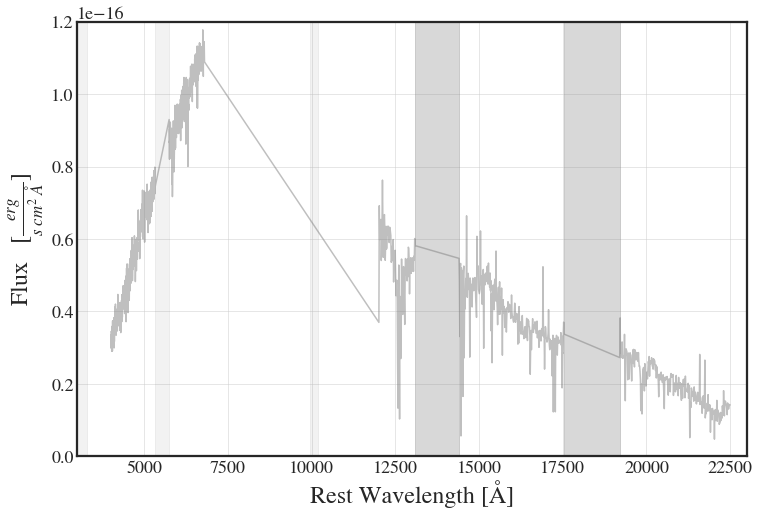

In [17]:
nbins=20
n_skip = int(np.shape(wl)[0])%nbins

wl_bin   = np.median(np.reshape(wl[n_skip:], (int(len(flux[n_skip:])/nbins), nbins )), axis=1)
flux_bin = np.average(np.reshape(flux[n_skip:], (int(len(flux[n_skip:])/nbins), nbins )), axis=1)#, 
                  #weights = 1/(np.reshape(error[n_skip:], (int(len(error[n_skip:])/nbins), nbins )))**2 )

#e_flux_bin = np.mean(np.reshape(error[4:], (int(len(error[4:])/10), 10 )), axis=1)
e_flux_bin = np.std(np.reshape(flux[n_skip:],(int(len(flux[n_skip:])/nbins), nbins )), axis=1)/np.sqrt(nbins-1)

len(flux_bin)

flux_bin   = flux_bin[~((wl_bin > 6800) & (wl_bin < 12000))]
e_flux_bin = e_flux_bin[~((wl_bin > 6800) & (wl_bin < 12000))]
wl_bin     = wl_bin[~((wl_bin > 6800) & (wl_bin < 12000))]


fig,ax = plt.subplots(figsize=(12,8))
plt.plot(wl_bin, flux_bin, label='X-shooter spectra', color='grey', alpha=0.5)

#plt.plot(wl,flux_fit, ls='--', color='k', label='Blackbody-fit')
#plt.fill_between(x[:,0], x[:,1]-x[:,2], x[:,1]+x[:,2],color='grey', alpha=0.9)
plt.ylim(0, 1.2e-16), plt.xlim(3000, 23000)

#define telluric region
ax.fill_between([13100, 14400], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )
ax.fill_between([17550, 19200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )

#poorly constrained regions
ax.fill_between([5330, 5740], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1   )
ax.fill_between([9940, 10200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

#define absorbtion feature
#ax.fill_between([7000, 9000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )
ax.fill_between([3000, 3300], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

plt.xlabel('Rest Wavelength [Å]'), plt.ylabel(r'Flux   $ [ \frac{erg}{s \ cm^2 \ Å} ] $'), 
ax.ticklabel_format(axis='x', style='plain')

In [18]:
from astropy.modeling import models

#area
x_arr = np.linspace(0, np.pi/2, 10)
x_center = (x_arr[1:]+x_arr[:-1])/2
areas = 2*np.sin(x_center)*np.cos(x_center) * (x_arr[1]-x_arr[0])

def p_cygni_line_corr(wl, v_out, v_phot, tau, lam, vref=0.2, ve=0.2, t0 = 120960): 
    prof_calc = PcygniCalculator(t=t0 * units.s, vmax=v_out * csts.c,
                                 vphot=v_phot * csts.c, tauref=tau, vref=vref *
                                 csts.c, ve=ve * csts.c,
                                 lam0=lam * units.AA)#, _lam_min=7000, _lam_max=13000)
    
    cyg = prof_calc.calc_profile_Flam( npoints=25 )  
    
    inter = interp1d(cyg[0].value*1e-10, cyg[1], bounds_error=False, fill_value=1)    
    return inter(wl)

@numba.njit(fastmath=True)
def temp(wav,T):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return a/ ( (wav**5)*(np.exp(b) - 1.0) )

@numba.njit(fastmath=True)
def temp2(wav,T,corr):
    wav = wav*corr
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return a/ ( (wav**5)*(np.exp(b) - 1.0) )
    
@numba.njit(fastmath=True)
def gaussian(wav, amp, mu, sigma): 
    return amp*np.exp(-(wav-mu)**2/(2*sigma**2))
    
p0 = np.array([-0.03371947,  0.32732845])  
    
def planck_with_mod(wav, T, N, v_out, v_phot, tau=0.55, occul = 1, ve=0.32,
                    amp1 = 2, cen1=15500, sig1=250,amp2 = 2, cen2=15500, sig2=250, 
                    vbb = 0.2, T_power = 0.54,
                    vref=0., t0=120960, lam=10506.3653): 
    
    #This includes the cooling of temperatures using Drout2017
    t = vbb*t0/(1-vbb) - np.cos(x_center) * (vbb*t0)/(1-vbb*np.cos(x_center))
    #print('corr=',corr)
    T_n = T*((t0-t)/t0)**(-T_power)
    #print('Tn=',T_n)

    vbb_n  = vbb #+(t0-t)/(3600*24)*p0[0]
    corr = (1-vbb_n**2)**(1/2)*1/(1-vbb_n*np.cos(x_center))  
    
    #intensity = np.average([temp2(wav, T_i, i)*i**5 for i,T_i in zip(corr,T_n)], axis=0, weights=areas)
    intensity = np.average([temp(wav, T_i*i) for i,T_i in zip(corr,T_n)], axis=0, weights=areas)
    
    #x = np.cos(x_center)
    #intensity = [np.trapz( 2*np.pi *  2*h*c**2/i**5 * 1/(np.exp(h*c/(k*T_n*i*(1/np.sqrt(1-vbb**2)/(1-vbb*x)) ))-1)*
    #       x, x=x ) for i in wav]
    
    #intensity = np.average([temp(wav*i, T_i)*i**5 for i,T_i in zip(corr,T_n)], axis=0, weights=areas)
    
    #intensity = temp(wav, 2*T)

    pcyg_prof3 = p_cygni_line_corr(wav, v_out, v_phot, 1/13.8*tau   , 10036.65, vref=vref, ve=ve , t0=t0)
    pcyg_prof4 = p_cygni_line_corr(wav, v_out, v_phot, 8.1/13.8*tau , 10327.311,vref=vref, ve=ve , t0=t0)
    pcyg_prof5 = p_cygni_line_corr(wav, v_out, v_phot, 4.7/13.8*tau , 10914.887,vref=vref, ve=ve , t0=t0)
    correction = pcyg_prof3*pcyg_prof4*pcyg_prof5
    correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    # Gaussians
    gau1 = gaussian(wav, 1e-17*amp1, cen1, sig1)
    gau2 = gaussian(wav, 1e-17*amp2, cen2, sig2)

    intensity = intensity*correction
    #print('delta = ', corr)
    #print('T_n = ', T_n)
    return N*intensity+gau1+gau2


def residual(pars, wav, data=None, error=None): 
    v = pars.valuesdict()
    T, N, vphot = v["T"], v["N"], v["vphot"]
    t0, vmax, tau, vref, ve, occult2 = v["t0"], v["vmax"], v["tau"], v["vref"], v["ve"], v["occult"]
    amp1, amp2, cen1, cen2, sig1, sig2= v["amp1"], v["amp2"], v["cen1"], v["cen2"], v["sig1"], v["sig2"]
    vbb = v['v_bb']
    T_power = v['T_power']
    
    
    model = planck_with_mod(wav, T, N, vmax, vphot, tau=tau, occul=occult2, ve = ve, vref = vref, 
                           amp1 = amp1, cen1=cen1, sig1=sig1, amp2 = amp2, cen2=cen2, sig2=sig2, t0=t0, 
                            vbb=vbb, T_power = T_power)
    
    if data is None:
        return model
    return (model - data)/error

import lmfit
beta, doppler = np.loadtxt('../doppler_with_cossin.txt')
inter = interp1d(beta, doppler)
print(inter(0.27))
def lum_dist_arr(N, vphot, n_days=1.43, dt=0.): #propagate bb to luminosity distance 
    delta = inter(vphot) #1-2/3*11/10*vphot
    corr = 1 #delta**5#**4
        
    theta = 2*np.sqrt( N*10**(7) / np.pi ) #/ corr inverse
    v = vphot*c 
    t = (n_days-dt) * (3600*24)
    r = v*t
    
    D = r/theta*2# factor of 2 
    D_mpc = D*(3.2408e-23) 
    return D_mpc


n_days = [1.427, 2.417, 3.413, 4.403]

1.1810756650794825


In [19]:
@numba.njit(fastmath=True)
def lnprob_inner(model, flux, error):
    return -0.5 * np.sum(((model - flux) / error)**2 + np.log(2 * np.pi * error**2))

def lnprob(pars):
    """This is the log-likelihood probability for the sampling."""    
    model = residual(pars, wl*1e-10)
    return lnprob_inner(model, flux, error)

#### Fit structure

In [20]:
p = lmfit.Parameters()
#OB = 'OB1'
pickle_in = open("../data/OB2/OB2_3_peaks_with_gaussian_1.pkl","rb")
res_n3 = pickle.load(pickle_in)
p = res_n3.params
p.add('T_power', value=0.50, min=0, max=1)
p.add('v_bb', value=0.25, min=0, max=1)
p['vphot'].vary= False; p['vmax'].vary = False; p['tau'].vary  = False
p['ve'].vary   = False; p['amp1'].vary = False; p['amp2'].vary = False 
p['occult'].vary=False; p['cen1'].vary = False; p['cen2'].vary = False
p['sig1'].vary = False; p['sig2'].vary = False
#p['T'].value = 3030
p['T_power'].vary = False
p['T'].vary = True
p

name,value,standard error,relative error,initial value,min,max,vary
T,3935.61945,2.10792907,(0.05%),3934.8594459404258,2500.00000,7500.00000,True
N,2.7520e-29,8.1075e-32,(0.29%),2.7550329862747807e-29,-inf,inf,True
vphot,0.24759564,6.0591e-04,(0.24%),0.24781409280561079,0.00000000,1.00000000,False
vmax,0.27924953,5.4341e-04,(0.19%),0.27939923960610835,0.00000000,1.00000000,False
t0,212400.000,,(0.19%),212400,-inf,inf,False
tau,1.72065717,0.14896297,(8.66%),1.8163532086079675,0.00000000,10.0000000,False
vref,0.00000000,,(8.66%),0.0,0.00000000,1.00000000,False
ve,0.78000760,0.17143558,(21.98%),0.774809458787137,0.00000000,1.00000000,False
occult,1.47274460,0.05392977,(3.66%),1.466828834576058,0.10000000,10.0000000,False
amp1,0.73192550,0.01154201,(1.58%),0.7278762857659176,0.01000000,5.00000000,False


In [130]:
pickle_in = open("../data/OB2/OB2_3_peaks_with_gaussian_1.pkl","rb")
p0 = pickle.load(pickle_in).params
p0.add('T_power', value=0.50, min=0, max=1)
p0.add('v_bb', value=0.25, min=0, max=1)

2.752046990957482e-29
2.6757795362235e-29
2.52231487904138e-29
2.6557587963177935e-29


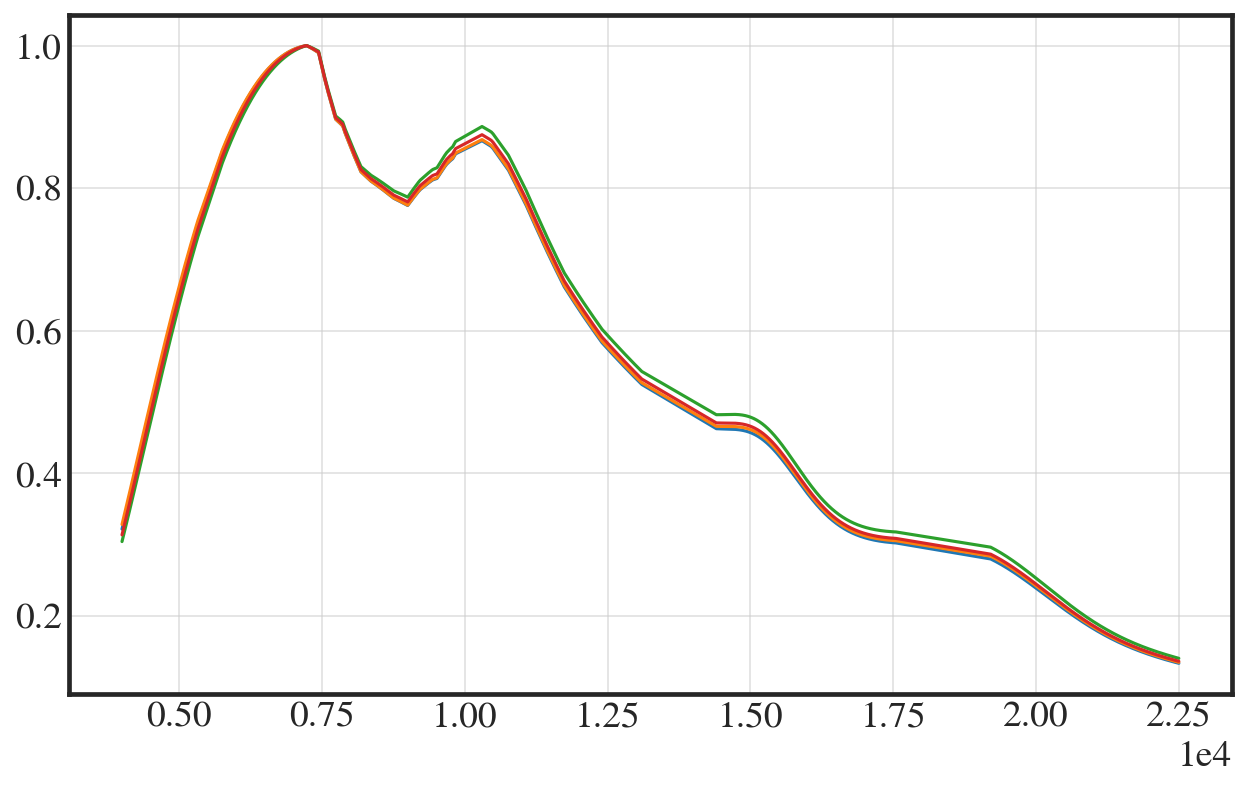

In [141]:
plt.figure(figsize=(10,6), dpi=150)
p0['T'].value=3935
p0['T_power'].value=0.0
p0['v_bb'].value = 0.0
plt.plot(wl, residual(p0, wl*1e-10)/max(residual(p0, wl*1e-10)) )
print(max(residual(p0, wl*1e-10))/max(residual(p0, wl*1e-10))*p['N'].value)

p['T'].value=3250
p['T_power'].value=0.20
p['v_bb'].value = 0.25
plt.plot(wl, residual(p, wl*1e-10)/max(residual(p, wl*1e-10)) )
print(max(residual(p, wl*1e-10))/max(residual(p0, wl*1e-10))*p['N'].value)

p['T'].value=3250
p['T_power'].value=0.40
p['v_bb'].value = 0.21
plt.plot(wl, residual(p, wl*1e-10)/max(residual(p, wl*1e-10)) )
print(max(residual(p, wl*1e-10))/max(residual(p0, wl*1e-10))*p['N'].value)

p['T'].value=3250
p['T_power'].value=0.60
p['v_bb'].value = 0.20
plt.plot(wl, residual(p, wl*1e-10)/max(residual(p, wl*1e-10)) )
print(max(residual(p, wl*1e-10))/max(residual(p0, wl*1e-10))*p['N'].value)


2.6557587963177935e-29
2.470077882488675e-29
2.390118814832495e-29


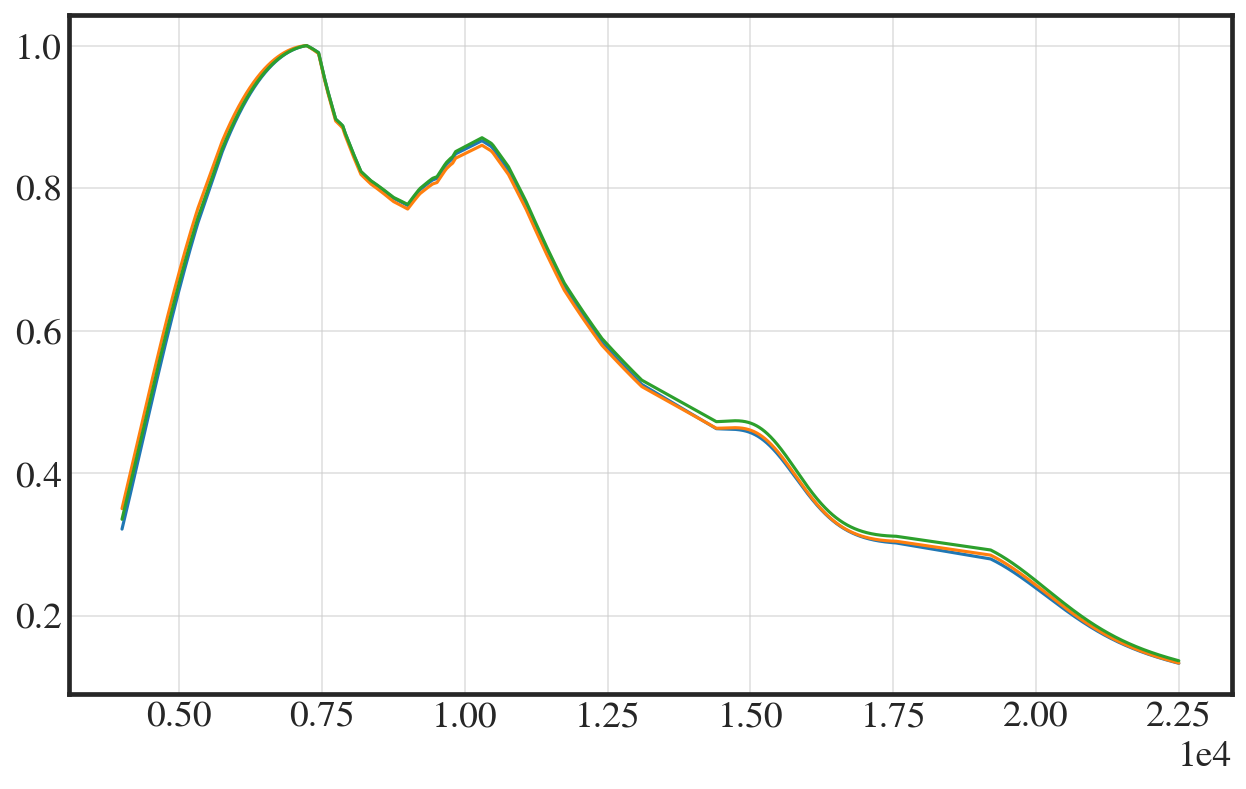

In [152]:
plt.figure(figsize=(10,6), dpi=150)
p0['T'].value=3935
p0['T_power'].value=0.0
p0['v_bb'].value = 0.0
plt.plot(wl, residual(p0, wl*1e-10)/max(residual(p0, wl*1e-10)) )
print(max(residual(p0, wl*1e-10))/max(residual(p0, wl*1e-10))*p['N'].value)

p['T'].value=3050
p['T_power'].value=0.10
p['v_bb'].value = 0.35
plt.plot(wl, residual(p, wl*1e-10)/max(residual(p, wl*1e-10)) )
print(max(residual(p, wl*1e-10))/max(residual(p0, wl*1e-10))*p['N'].value)

p['T'].value=3100
p['T_power'].value=0.10
p['v_bb'].value = 0.32
plt.plot(wl, residual(p, wl*1e-10)/max(residual(p, wl*1e-10)) )
print(max(residual(p, wl*1e-10))/max(residual(p0, wl*1e-10))*p['N'].value)


For  0.0 , then vbb =  <Parameter 'v_bb', value=0.0005993594573306393, bounds=[0:1]>
For  0.1 , then vbb =  <Parameter 'v_bb', value=1.3928879680824569e-05, bounds=[0:1]>
For  0.2 , then vbb =  <Parameter 'v_bb', value=3.098821120905981e-05, bounds=[0:1]>
For  0.4 , then vbb =  <Parameter 'v_bb', value=0.00028864973668396576, bounds=[0:1]>
For  0.6 , then vbb =  <Parameter 'v_bb', value=0.23398072301359701, bounds=[0:1]>


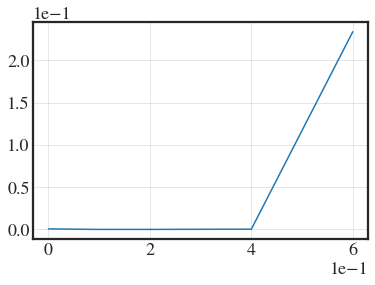

In [21]:
#Excluding Sr wavelengths

mi_list = []
N = [2.752046990957482e-29, 2.470077882488675e-29, 2.6757795362235e-29, 2.52231487904138e-29, 2.6557587963177935e-29]
T = [3935, 3050, 3250, 3250, 3250]
vbb = [0.0, 0.35, 0.25, 0.21, 0.20]
for i,T_pow in enumerate([0.0, 0.1, 0.20, 0.40, 0.60]): 
    p['T_power'].vary=False
    p['T_power'].value=T_pow
    p['v_bb'].value=vbb[i]
    p['T'].value=T[i]
    p['N'].value=N[i]
    
    mi2 = lmfit.minimize(residual, p, method='Nelder', args=(wl*1e-10, flux, error))
    mi_list.append(mi2)
    
    print('For ', T_pow, ', then vbb = ', mi2.params['v_bb'])
    
v_bb_list = []
for i in range(len(mi_list)): 
    mi = mi_list[i]
    v_bb_list.append(mi.params['v_bb'].value)

plt.plot([0.0, 0.1, 0.20, 0.40, 0.60], v_bb_list)

For  0.0 , then vbb =  <Parameter 'v_bb', value=0.0005993594573306393, bounds=[0:1]>
For  0.1 , then vbb =  <Parameter 'v_bb', value=1.3928879680824569e-05, bounds=[0:1]>
For  0.2 , then vbb =  <Parameter 'v_bb', value=3.098821120905981e-05, bounds=[0:1]>
For  0.4 , then vbb =  <Parameter 'v_bb', value=0.00028864973668396576, bounds=[0:1]>
For  0.6 , then vbb =  <Parameter 'v_bb', value=0.23398072301359701, bounds=[0:1]>


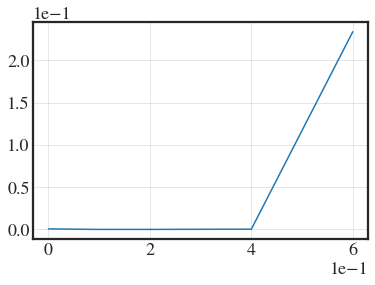

In [11]:
#p['v_bb'].value=0.30  ; p['v_bb'].vary=False  

mi_list = []
N = [2.752046990957482e-29, 2.470077882488675e-29, 2.6757795362235e-29, 2.52231487904138e-29, 2.6557587963177935e-29]
T = [3935, 3050, 3250, 3250, 3250]
vbb = [0.0, 0.35, 0.25, 0.21, 0.20]
for i,T_pow in enumerate([0.0, 0.1, 0.20, 0.40, 0.60]): 
    p['T_power'].vary=False
    p['T_power'].value=T_pow
    p['v_bb'].value=vbb[i]
    p['T'].value=T[i]
    p['N'].value=N[i]
    
    mi2 = lmfit.minimize(residual, p, method='Nelder', args=(wl*1e-10, flux, error))
    mi_list.append(mi2)
    
    print('For ', T_pow, ', then vbb = ', mi2.params['v_bb'])
    
v_bb_list = []
for i in range(len(mi_list)): 
    mi = mi_list[i]
    v_bb_list.append(mi.params['v_bb'].value)

plt.plot([0.0, 0.1, 0.20, 0.40, 0.60], v_bb_list)

In [162]:
#p['v_bb'].value=0.30  ; p['v_bb'].vary=False  
#p['vphot'].vary= True; p['vmax'].vary = True; p['tau'].vary  = True
#p['ve'].vary   = True; p['occult'].vary=True

res_list = []
v_bb_list = []
dv_bb_list = [] #0.55, 
#N = [2.752046990957482e-29, 2.470077882488675e-29, 2.6757795362235e-29, 2.52231487904138e-29, 2.6557587963177935e-29]
#T = [3935, 3050, 3250, 3250, 3250]
#vbb = [0.0, 0.35, 0.25, 0.21, 0.20]

for i,T_pow in enumerate([ 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55]): 
    p['T_power'].vary=False
    p['T_power'].value=T_pow
    #p['v_bb'].value=vbb[i]
    #p['T'].value=T[i]
    #p['N'].value=N[i]
    
    mini = lmfit.Minimizer(lnprob, p) 

    nwalkers = 20
    res5 = mini.emcee(nwalkers=nwalkers, burn=0, steps=2500, thin=1, params=p, seed=12345, workers = 4)
    res_list.append(res5)
    v_bb_list.append(res5.params['v_bb'].value)
    dv_bb_list.append(np.std(res5.flatchain['v_bb']))

    print('vbb, Tpow = ', res5.params['v_bb'], T_pow)
    with open("Conv2/Epoch2_Tpow_"+str(T_pow)+".pkl", 'wb') as outfile:
            pickle.dump(res5, outfile) 

100%|██████████| 2500/2500 [23:33<00:00,  1.77it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [155.63508216  67.30204533 156.03408014]
vbb, Tpow =  <Parameter 'v_bb', value=0.017027583793963047 +/- 0.0182, bounds=[0:1]> 0.6


100%|██████████| 2500/2500 [27:02<00:00,  1.54it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [205.31996623  84.70754328 205.75699757]
vbb, Tpow =  <Parameter 'v_bb', value=0.28975876066673606 +/- 0.0249, bounds=[0:1]> 0.65


100%|██████████| 2500/2500 [23:02<00:00,  1.81it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [203.98456802  96.59539719 203.11373566]
vbb, Tpow =  <Parameter 'v_bb', value=0.21945130893817494 +/- 0.122, bounds=[0:1]> 0.7


100%|██████████| 2500/2500 [27:33<00:00,  1.51it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [145.05838476  69.1967532  144.42553589]
vbb, Tpow =  <Parameter 'v_bb', value=0.21197261970664807 +/- 0.0267, bounds=[0:1]> 0.75


100%|██████████| 2500/2500 [24:08<00:00,  1.73it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [165.66246526  60.64777004 165.79032713]
vbb, Tpow =  <Parameter 'v_bb', value=0.13501606112573844 +/- 0.0828, bounds=[0:1]> 0.8


100%|██████████| 2500/2500 [23:52<00:00,  1.74it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [121.24549104  53.39480242 121.91496049]
vbb, Tpow =  <Parameter 'v_bb', value=0.11030569613363142 +/- 0.0678, bounds=[0:1]> 0.85


100%|██████████| 2500/2500 [23:24<00:00,  1.78it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [126.56794922  26.57076834 129.22778903]
vbb, Tpow =  <Parameter 'v_bb', value=0.008040364159996628 +/- 0.00782, bounds=[0:1]> 0.1


100%|██████████| 2500/2500 [23:19<00:00,  1.79it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [167.79349917  23.79743483 170.58364085]
vbb, Tpow =  <Parameter 'v_bb', value=0.008383781454640242 +/- 0.0089, bounds=[0:1]> 0.15


100%|██████████| 2500/2500 [23:07<00:00,  1.80it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [126.60860789  26.59564491 128.68711457]
vbb, Tpow =  <Parameter 'v_bb', value=0.008164829793974777 +/- 0.00836, bounds=[0:1]> 0.2


100%|██████████| 2500/2500 [23:08<00:00,  1.80it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [128.38133795  25.59888515 129.94276773]
vbb, Tpow =  <Parameter 'v_bb', value=0.008421141703168196 +/- 0.00902, bounds=[0:1]> 0.25


100%|██████████| 2500/2500 [23:04<00:00,  1.81it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [133.38926164  34.08893834 134.86890637]
vbb, Tpow =  <Parameter 'v_bb', value=0.010046473019419948 +/- 0.0102, bounds=[0:1]> 0.3


100%|██████████| 2500/2500 [23:07<00:00,  1.80it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [142.68713031  29.96150245 143.59451152]
vbb, Tpow =  <Parameter 'v_bb', value=0.010835284753693447 +/- 0.0109, bounds=[0:1]> 0.35


100%|██████████| 2500/2500 [23:04<00:00,  1.81it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [137.22102421  37.49822761 137.6950695 ]
vbb, Tpow =  <Parameter 'v_bb', value=0.012339316517047349 +/- 0.0122, bounds=[0:1]> 0.4


100%|██████████| 2500/2500 [23:10<00:00,  1.80it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [114.7736009   55.41497032 115.29062573]
vbb, Tpow =  <Parameter 'v_bb', value=0.012932476738079287 +/- 0.0125, bounds=[0:1]> 0.45


100%|██████████| 2500/2500 [23:17<00:00,  1.79it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [120.38838072  66.40554293 120.70167338]
vbb, Tpow =  <Parameter 'v_bb', value=0.014733159156290063 +/- 0.0144, bounds=[0:1]> 0.5


100%|██████████| 2500/2500 [23:09<00:00,  1.80it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [95.57048166 78.88328156 95.84151442]
vbb, Tpow =  <Parameter 'v_bb', value=0.015947976947616488 +/- 0.015, bounds=[0:1]> 0.55


In [161]:
p

name,value,standard error,relative error,initial value,min,max,vary
T,3250.00000,2.10792907,(0.06%),3934.8594459404258,2500.00000,7500.00000,True
N,2.6558e-29,8.1075e-32,(0.31%),2.7550329862747807e-29,-inf,inf,True
vphot,0.24759564,6.0591e-04,(0.24%),0.24781409280561079,0.00000000,1.00000000,False
vmax,0.27924953,5.4341e-04,(0.19%),0.27939923960610835,0.00000000,1.00000000,False
t0,212400.000,,(0.19%),212400,-inf,inf,False
tau,1.72065717,0.14896297,(8.66%),1.8163532086079675,0.00000000,10.0000000,False
vref,0.00000000,,(8.66%),0.0,0.00000000,1.00000000,False
ve,0.78000760,0.17143558,(21.98%),0.774809458787137,0.00000000,1.00000000,False
occult,1.47274460,0.05392977,(3.66%),1.466828834576058,0.10000000,10.0000000,False
amp1,0.73192550,0.01154201,(1.58%),0.7278762857659176,0.01000000,5.00000000,False


In [163]:
files = os.listdir('Conv2')
T_power_list = []
v_bb_list = []
dv_bb_list = []
temp = []
N = []
for file in files[::-1]: 
    pickle_in = open('Conv2/'+file, "rb")
    res2 = pickle.load(pickle_in)
    p = res2.params
    
    if ((res2.params['T_power'].value != 0.65) & (res2.params['T_power'].value != 0.9)):
        T_power_list.append(res2.params['T_power'].value)
        v_bb_list.append(res2.params['v_bb'].value)
        dv_bb_list.append(np.std(res2.flatchain['v_bb'][:]) ) #res2.params['v_bb'].stderr)
        temp.append(res2.params['T'].value)
        N.append(res2.params['N'].value)
    
T_power_list = np.array(T_power_list)
v_bb_list = np.array(v_bb_list)
dv_bb_list = np.array(dv_bb_list)

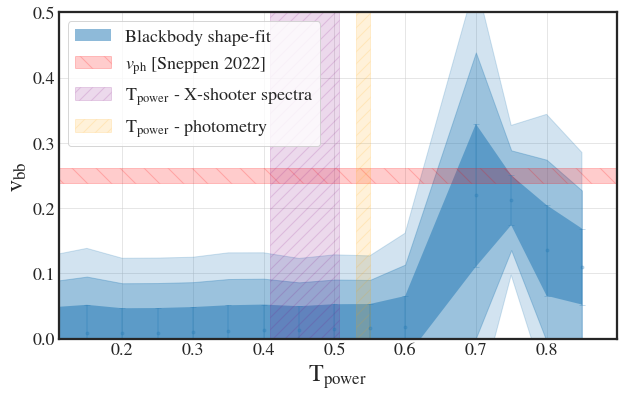

In [168]:
fig, ax = plt.subplots(figsize=(10,6))
plt.errorbar(T_power_list, v_bb_list, yerr=dv_bb_list, 
             capsize=3, fmt='.', alpha=0.25)
plt.fill_between(T_power_list, np.array(v_bb_list)-np.array(dv_bb_list), 
                     np.array(v_bb_list)+np.array(dv_bb_list), alpha=0.5, 
                     label='Blackbody shape-fit')
plt.fill_between(T_power_list, np.array(v_bb_list)-2*np.array(dv_bb_list), 
                     np.array(v_bb_list)+2*np.array(dv_bb_list), alpha=0.3, color='C0')
plt.fill_between(T_power_list, np.array(v_bb_list)-3*np.array(dv_bb_list), 
                     np.array(v_bb_list)+3*np.array(dv_bb_list), alpha=0.2, color='C0')

plt.xlabel(r'${\rm T_{power} }$'), plt.ylabel(r'${\rm v_{bb} }$') 
plt.xlim(0.11, 0.899), plt.ylim(0.0, 0.50)
ax.ticklabel_format(axis='both', style='plain')

plt.fill_between(np.linspace(0, 0.90), 0.262*np.ones_like(np.linspace(0, 0.70)), 
                 y2=0.238*np.ones_like(np.linspace(0, 0.70)), color='red', alpha=0.2, 
                 label=r'$v_{\rm ph}$ [Sneppen 2022]', hatch='\\')
plt.fill_betweenx(np.linspace(0, 0.90), (0.458+0.049)*np.ones_like(np.linspace(0, 0.70)), 
                 x2=(0.458-0.049)*np.ones_like(np.linspace(0, 0.70)), color='purple', alpha=0.15, 
                 label=r'${\rm T}_{\rm power}$ - X-shooter spectra', hatch='//')

plt.fill_betweenx(np.linspace(0, 0.90), 0.53*np.ones_like(np.linspace(0, 0.70)), 
                  x2=0.55*np.ones_like(np.linspace(0, 0.70)), color='orange', alpha=0.15,
                  label=r'${\rm T}_{\rm power}$ - photometry', hatch='//')


plt.legend(frameon=True, fontsize=18, loc=2)
#plt.xscale('log')

#plt.savefig('../Pictures/Convolved_BB_1.png', dpi=300)

In [90]:
0.25*1.048, 0.25/1.048

(0.262, 0.23854961832061067)

In [32]:
start = time.time()
mi2 = lmfit.minimize(residual, p, method='Nelder', args=(wl*1e-10, flux, error))
end = time.time()
print('Time elapsed:',(end-start)/60) 
mi2.params

Time elapsed: 0.34456218481063844


name,value,initial value,min,max,vary
T,3030.00000,3030,2500.00000,7500.00000,False
N,2.7554e-29,2.752046990957482e-29,-inf,inf,True
vphot,0.24759564,0.24759563525437875,0.00000000,1.00000000,False
vmax,0.27924953,0.27924953077917924,0.00000000,1.00000000,False
t0,212400.000,212400,-inf,inf,False
tau,1.72065717,1.7206571723678954,0.00000000,10.0000000,False
vref,0.00000000,0.0,0.00000000,1.00000000,False
ve,0.78000760,0.780007595922463,0.00000000,1.00000000,False
occult,1.47274460,1.4727446008300493,0.10000000,10.0000000,False
amp1,0.73192550,0.731925498290273,0.01000000,5.00000000,False


In [65]:
mini = lmfit.Minimizer(lnprob, p) 
#p['T'].vary = True

start = time.time()
nwalkers = 20 #v = p.valuesdict()
#res6 = mini.emcee(nwalkers=nwalkers, burn=0, steps=2000, thin=1, params=p, seed=12345, workers = 4)
end = time.time()

print('Time elapsed [hours]:',(end-start)/60/60 ) 

Time elapsed [hours]: 0.0


In [66]:
p

name,value,standard error,relative error,initial value,min,max,vary
T,3030.00000,2.10792907,(0.07%),3934.8594459404258,2500.00000,7500.00000,True
N,2.7520e-29,8.1075e-32,(0.29%),2.7550329862747807e-29,-inf,inf,True
vphot,0.24759564,6.0591e-04,(0.24%),0.24781409280561079,0.00000000,1.00000000,False
vmax,0.27924953,5.4341e-04,(0.19%),0.27939923960610835,0.00000000,1.00000000,False
t0,212400.000,,(0.19%),212400,-inf,inf,False
tau,1.72065717,0.14896297,(8.66%),1.8163532086079675,0.00000000,10.0000000,False
vref,0.00000000,,(8.66%),0.0,0.00000000,1.00000000,False
ve,0.78000760,0.17143558,(21.98%),0.774809458787137,0.00000000,1.00000000,False
occult,1.47274460,0.05392977,(3.66%),1.466828834576058,0.10000000,10.0000000,False
amp1,0.73192550,0.01154201,(1.58%),0.7278762857659176,0.01000000,5.00000000,False


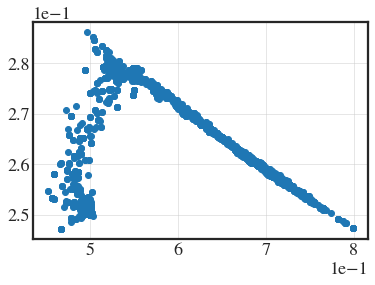

In [39]:
plt.scatter(res4.flatchain['T_power'], res4.flatchain['v_bb'])

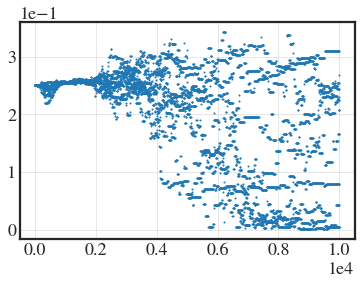

In [49]:
plt.scatter( np.arange(len(res5.flatchain['v_bb'])), res5.flatchain['v_bb'], s=1)

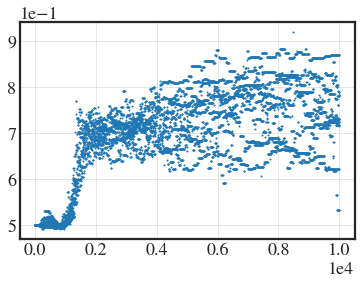

In [50]:
plt.scatter( np.arange(len(res5.flatchain['v_bb'])), res5.flatchain['T_power'], s=1)

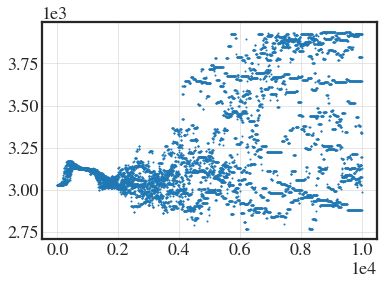

In [51]:
plt.scatter( np.arange(len(res5.flatchain['v_bb'])), res5.flatchain['T'], s=1)

((0.0, 0.9), (0.0, 0.5), None)

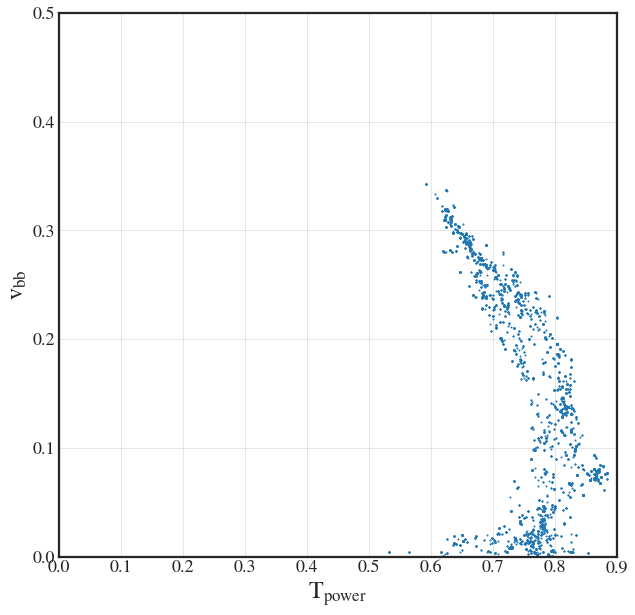

In [59]:
fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(res5.flatchain['T_power'][5000:], res5.flatchain['v_bb'][5000:], s=1)
plt.xlabel(r'${\rm T_{power} }$'), plt.ylabel(r'${\rm v_{bb} }$')
plt.xlim(0, 0.90), plt.ylim(0, 0.50), ax.ticklabel_format(axis='both', style='plain')


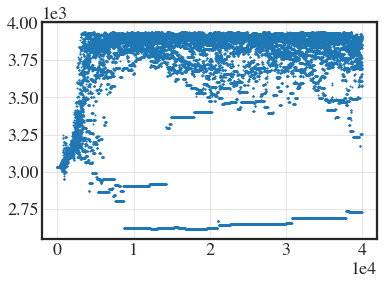

In [64]:
plt.scatter( np.arange(len(res6.flatchain['v_bb'])), res6.flatchain['T'], s=1)

((0.0, 0.9), (0.0, 0.5), None)

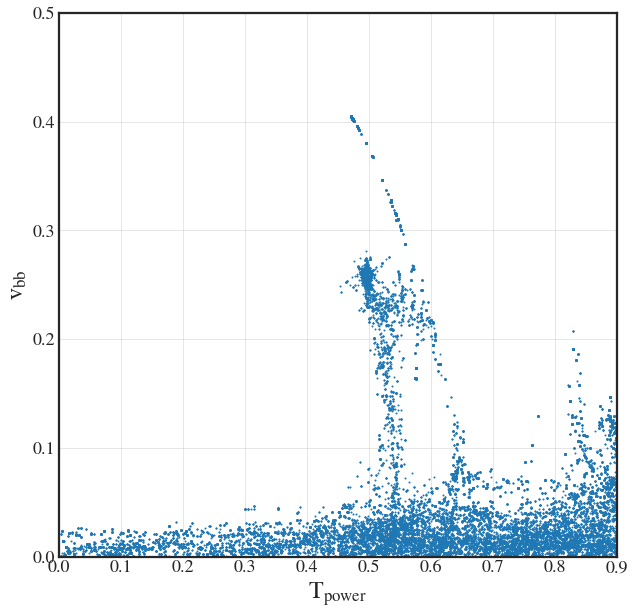

In [63]:
fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(res6.flatchain['T_power'], res6.flatchain['v_bb'], s=1)
plt.xlabel(r'${\rm T_{power} }$'), plt.ylabel(r'${\rm v_{bb} }$')
plt.xlim(0, 0.90), plt.ylim(0, 0.50), ax.ticklabel_format(axis='both', style='plain')


In [23]:
3950/1.3

3038.4615384615386

In [24]:
p = mi2.params

In [25]:
print(lum_dist_arr(mi2.params['N'],mi2.params['vphot'],n_days=2.43) )
mi2.params['T'], mi2.params['vphot'], mi2.params['v_bb'], mi2.params['T_power'], mi2.params['N'], mi2.params['vmax']

54.072498449813544


(<Parameter 'T', value=3938.0802998867257, bounds=[2500:7500]>,
 <Parameter 'vphot', value=0.24759563525437875 (fixed), bounds=[0:1]>,
 <Parameter 'v_bb', value=3.0564765720220155e-05, bounds=[0:1]>,
 <Parameter 'T_power', value=0.5 (fixed), bounds=[0:1]>,
 <Parameter 'N', value=2.744542559876677e-29, bounds=[-inf:inf]>,
 <Parameter 'vmax', value=0.27924953077917924 (fixed), bounds=[0:1]>)